In [1]:
!unzip -o "testdaten_edit_06.06.25.zip" -d "testdaten_edit_06.06.25"

Archive:  testdaten_edit_06.06.25.zip
 extracting: testdaten_edit_06.06.25/0d3ca394ec4721bbb7040cc8be8a0e2c1881a50cf08399715eb3305b0769eb4a.json  
 extracting: testdaten_edit_06.06.25/3b34ee5ba8285beb05f42aeaa12f39ec10dd6e00643cce3eea50a78086e97d3c.json  
 extracting: testdaten_edit_06.06.25/4acf957e62cdf103c91a780b47faed6f08e669a70152f140f83b98072efb462f.json  
 extracting: testdaten_edit_06.06.25/4b3445e44d2729ab3ea8723f91e819edd09754dcd5d0e514564110c34322d74d.json  
 extracting: testdaten_edit_06.06.25/4fd06b5bff15c1178546f382964793baaf0a0c8af66b92b81dc8b6cd3504aab0.json  
 extracting: testdaten_edit_06.06.25/5dcf27da9477a18d0103ef7b61efe7b40cfffd9346eba5d2b777256120ed797c.json  
 extracting: testdaten_edit_06.06.25/5dd435a5190b43923ab1ab4173f5cc74e002e9162561df3cc39b037bb0096ada.json  
 extracting: testdaten_edit_06.06.25/5fd1ebc847703519f45eededc84f216cbc191cea99390dda1a5fc9b6291e5dcd.json  
 extracting: testdaten_edit_06.06.25/06a7dca0f637d59b11620203fd22309cf52ce7cf41363c51e2224

# Pathling Workshop
## Getting started
### Testdaten Download: https://cloud.uk-erlangen.de/s/qS9BcyYLcpAJWH7

### Relevante Links:
#### https://build.fhir.org/fhirpath.html
#### https://hl7.github.io/fhirpath.js/
#### https://www.basisdatensatz.de/basisdatensatz
#### https://simplifier.net/guide/mii-ig-modul-onkologie-2024-de/MIIIGModulOnkologie?version=current

In [2]:
!apt update
!apt install -y openjdk-17-jdk-headless
!pip install pathling==7.2.0 pandas==2.2.2 matplotlib==3.9.1

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,742 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,021 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1

# Einführung in die FHIR-Datenextraktion und -analyse mit Pathling

In [3]:
from pathling import PathlingContext, Expression as exp
from pyspark.sql import SparkSession

from pyspark.sql.functions import col, regexp_replace, to_date

spark = (
    SparkSession.builder.config(
        "spark.jars.packages",
        "au.csiro.pathling:library-runtime:7.2.0,",
        # "io.delta:delta-core_2.12:2.4.0,"
        # "org.apache.hadoop:hadoop-aws:3.3.4",
    )
    .config("spark.executor.memory", "8g")
    .config("spark.driver.memory", "10g")
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
    .getOrCreate()
)

spark.sparkContext.setCheckpointDir("/tmp")

pc = PathlingContext.create(
    spark=spark,
    enable_extensions=True,
    enable_delta=True,
    enable_terminology=False,
)

In [4]:
### Load Patient Data
# Wir laden die einzelnen FHIR-Bundles in eine Pathling data source

# !!Vorher müssen die json-Files in den Ordner data/ hier in die Laufzeit hochgeladen werden!!
# TO DO: curl repo and download images here

data = pc.read.bundles(
    "./testdaten_edit_06.06.25", ["Patient", "Condition", "Observation", "Procedure"]
)

In [5]:
data

_______________________________________________________________________

# MII Resourcen - Erweiterungsmodul Onkologie
## Implementation Guide
https://simplifier.net/guide/mii-ig-modul-onkologie-2024-de/MIIIGModulOnkologie?version=current

# THEMEN:
## 1. Extract
## 2. Combining Resource Types
### 2.1 Join
### 2.2 Resolve
### 2.3 ReverseResolve
## 3. GROUP EXERCISE: 4 entities
### 3.1 Diagnosis frequency
### 3.2 Gender distribution
### 3.3 Age distribution
### 3.4 Therapy analysis: surgery, radiotherapy
### 3.5 Free Analysis - or time for group work brain storming
________________________________________________________________________

# 1. Extract

## PATIENT -- RESOURCENTYP: PATIENT
https://www.medizininformatik-initiative.de/Kerndatensatz/Modul_Person_Version_2/MIIIGModulPerson-TechnischeImplementierung-FHIR-Profile-PseudonymisiertePatientinPatient.html

In [6]:
### Extract Patient Data

# Wir nutzen `extract`, um nur den Resourcentyp Patient aus der Pathling datasource zu extrahieren und in einen Pyspark Dataframe zu laden
# mithilfe von FHIR Path Ausdrücken können wir in Arrays verschachtelte FHIR Elemente "ausklappen" und als Spalte darstellen
# exp("<FHIR Path Ausdruck>", "<Spaltenname>")

# Dabei extrahieren wir:
# - die einmalige FHIR Resource ID für jede Patientenresource
# - die pseudonymisierte Patienten-ID
# - das Geschlecht
# - das Geburtsdatum
# - das Sterbedatum

patients = data.extract(
    "Patient",
    columns=[
        exp("id", "patient_resource_id"),
        exp(
            "identifier.where(type.coding.where(system='http://terminology.hl7.org/CodeSystem/v2-0203' and code='MR').exists()).value",
            "patid_pseudonym",
        ),
        exp("gender", "gender"),
        exp("birthDate", "birth_date"),
        exp("deceasedDateTime", "deceased_datetime"),
    ],
)

# da die extract Funktion relativ resourcenintensiv werden kann in Abhängigkeit der Datenmenge, und da Spark "lazy" agiert, lohnt es sich hier Spark Checkpoint einzusetzen
# "lazy" bedeutet, dass Spark alle Befehle in einer To Do Liste sammelt und erst nach einer "Action" ausführt.
# Außerdem speichert Spark keinen materialisierten Zwischenstand des dataframes, wenn man das nicht ausdrücklich verlangt
# mithilfe des Checkpoints können wir einen solchen Zwischenstand des dataframes zwischenspeichern und verhindern somit, dass Spark dieselben Schritte immer wieder ausführt
# das "count" brauchen wir hier als Action, damit auch der checkpoint sofort ausgeführt wird und nicht aufgrund der "laziness" in die To Do Liste wandert
# mithilfe von spark.sparkContext.setCheckpointDir() können wir den Speicherort der Checkpoints festlegen

patients = patients.checkpoint(eager=True)
patients_count = patients.count()  # enforce checkpoint

print(patients_count)

72


In [7]:
patients.show(72)

+-------------------+----------------+------+----------+-----------------+
|patient_resource_id| patid_pseudonym|gender|birth_date|deceased_datetime|
+-------------------+----------------+------+----------+-----------------+
|   60271b372396f53a|2f4017ec9a0d48c3|female|1954-06-30|       2024-07-25|
|   733b6df2aeaaff06|897acc358f405500|female|1935-08-21|       2019-06-25|
|   114b17715cd8962f|7a258cbfec3c558c|  male|1948-12-06|       2023-11-10|
|   64ffc8f6e2a04bf5|1f8367d0b53064c2|  male|1940-06-22|       2024-04-16|
|   9ba79939ecbcae8f|550d43f7d5cc0b99|  male|1952-03-09|       2019-04-09|
|   a1d728be37480030|6e98dce2f6665e34|  male|1985-09-20|             NULL|
|   ce38bdeb6979b366|fd59faa459aa1b58|female|2006-03-11|             NULL|
|   9a80d68214de0bd4|0fe7da3a23578158|female|1946-12-16|             NULL|
|   4a58365a0b7626a8|6c361d87cf623ee9|female|1962-10-25|             NULL|
|   ba3253fe6ca96286|ad09e0030f7313f6|  male|1947-09-06|             NULL|
|   847d834b896e3a1d|874d

In [8]:
# good practice: immer die Gesamtanzahl im Auge behalten
# weil: potentiell explosionsartiges Duplizieren
# z.B. mit count distinct resource ids --> manchmal kann ein zu ungenau spezifiziertes extract der Arrays dazu führen, dass durch das Aufklappen eines Arrays
# mit mehr als einem Element mehrere Zeilen pro Patient (oder Diagnose, etc) erzeugt werden
patients.select("patient_resource_id").distinct().count()

72

In [9]:
# Übung: Wieviele Patient*innen unserer Kohorte sind verstorben und wieviele leben noch bzw. haben keine Sterbeinformation?

## LÖSUNG:
verstorben = patients.filter(col("deceased_datetime").isNotNull()).count()
lebend = patients.filter(col("deceased_datetime").isNull()).count()

print("Verstorben:", verstorben, ", lebend oder unbekannt:", lebend)

Verstorben: 5 , lebend oder unbekannt: 67


## PRIMAERDIAGNOSE -- RESOURCENTYP: CONDITION
https://simplifier.net/guide/mii-ig-modul-onkologie-2024-de/MIIIGModulOnkologie/TechnischeImplementierung/FHIR-Profile/Diagnose/Diagnose-Condition.page.md?version=current

In [10]:
# wir extrahieren alle Diagnosen - jede Diagnose hat eine eindeutige ID
# wieviele eindeutige Diagnosen haben wir?

conditions = data.extract(
    "Condition",
    columns=[
        exp("id", "condition_resource_id"),
    ],
)
conditions = conditions.checkpoint(eager=True)
conditions_count = conditions.count()  # enforce checkpoint

print(conditions_count)

72


In [11]:
# good practice: count distinct ids
conditions.select("condition_resource_id").distinct().count()

72

In [12]:
# dazu extrahieren wir den ICD10 Diagnose Code

# "where" in der FHIR Path Expression exp...() ist die Projektion (analog zu WHERE in SQL)
# das "where" im Filter ist die tatsächliche Selektion (analog zu SELECT in SQL)

conditions = data.extract(
    "Condition",
    columns=[
        exp("id", "condition_resource_id"),
        exp(
            "code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').code",  # explizit system angeben, falls es noch weitere Codings mit anderen Systemen gibt
            "icd10_code",
        ),
    ],
    filters=[
        "code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').exists()"  # explizit System nochmal selektieren, um NULL rows zu entfernen, die durch andere Codings ggf. entstehen
    ],
)

conditions = conditions.checkpoint(eager=True)
conditions_count = conditions.count()  # enforce checkpoint

print(conditions_count)

72


In [13]:
# Welche Diagnosen kommen in unserem Datensatz vor?

icd10_codes = (
    conditions.select("icd10_code")
    .distinct()
    .orderBy("icd10_code")
    .rdd.flatMap(lambda x: x)
    .collect()
)
icd10_codes

['C15.3',
 'C15.4',
 'C15.5',
 'C15.9',
 'C18.0',
 'C18.1',
 'C18.2',
 'C18.3',
 'C18.4',
 'C18.7',
 'C18.8',
 'C25.0',
 'C25.1',
 'C25.2',
 'C71.0',
 'C71.1',
 'C71.2',
 'C71.5',
 'D33.1',
 'D43.0',
 'D43.1']

In [14]:
# Achtung vor explodierenden row counts und Duplikaten!

# die Duplikation entsteht erst wenn ein Element auf condition ebene (höher als code.coding.code Ebene) hinzukommt zum
# framework macht intern einen cross join
# https://pathling.csiro.au/docs/server/operations/extract --> siehe Abschnitt "Notes"
conditions = data.extract(
    "Condition",
    columns=[
        exp("id", "condition_resource_id"),
        exp(
            "code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').code",
            "icd10_code",
        ),  # kardinalität 0...1
        exp(
            "extension('http://hl7.org/fhir/StructureDefinition/condition-assertedDate').valueDateTime",
            "date_diagnosis",
        ),  # kardinalität 1..1
    ],
    filters=[
        "code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').exists()",
    ],
)

conditions = conditions.checkpoint(eager=True)
conditions_count = conditions.count()  # enforce checkpoint

print("Falscher count: ", conditions_count)

Falscher count:  144


In [15]:
print(
    "distinct id count ist immer noch:",
    conditions.select("condition_resource_id").distinct().count(),
)

distinct id count ist immer noch: 72


In [16]:
# hier siehst du, dass dupliziert wurde --> jede condition_resource_id kommt jetzt 2x vor
conditions.show()

+---------------------+----------+--------------+
|condition_resource_id|icd10_code|date_diagnosis|
+---------------------+----------+--------------+
|     6b612dd173fa5544|     C18.0|    2023-08-20|
|     6b612dd173fa5544|     C18.0|          NULL|
|     08e306e6917943c2|     C15.4|    2024-02-29|
|     08e306e6917943c2|     C15.4|          NULL|
|     afc792bfaea32585|     C25.0|    2022-12-25|
|     afc792bfaea32585|     C25.0|          NULL|
|     8a7f134a200e57c1|     C25.1|    2024-02-18|
|     8a7f134a200e57c1|     C25.1|          NULL|
|     5927a5135224b9f5|     C18.7|    2023-10-30|
|     5927a5135224b9f5|     C18.7|          NULL|
|     b28d21fb5d6a4bc8|     C25.0|    2019-03-07|
|     b28d21fb5d6a4bc8|     C25.0|          NULL|
|     d80a996d35bb0d68|     C18.2|    2024-06-19|
|     d80a996d35bb0d68|     C18.2|          NULL|
|     e72e5f5440a7ffc5|     C25.0|    2022-07-06|
|     e72e5f5440a7ffc5|     C25.0|          NULL|
|     1f080c26891c70a0|     C18.0|    2023-02-11|


In [17]:
# wir brauchen da ein first wo wir sicher sind, dass es nur max. einmal vorkommen kann --> Stichwort Kardinalitäten (0...1 oder 1...1)
conditions = data.extract(
    "Condition",
    columns=[
        exp("id", "condition_resource_id"),
        exp(
            "code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').code.first()",
            "icd10_code",
        ),  # kardinalität 0...1
        exp(
            "extension('http://hl7.org/fhir/StructureDefinition/condition-assertedDate').valueDateTime.first()",
            "date_diagnosis",
        ),  # kardinalität 1..1
        exp("recordedDate", "recorded_date"),
    ],
    filters=[
        "code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').exists()",
    ],
)

conditions = conditions.checkpoint(eager=True)
conditions_count = conditions.count()  # enforce checkpoint

print(conditions_count)

72


In [18]:
# hier siehst du jetzt, dass die doppelte Zeile mit condition_resource_id korrekterweise wieder entfernt wurde
conditions.show()

+---------------------+----------+--------------+-------------+
|condition_resource_id|icd10_code|date_diagnosis|recorded_date|
+---------------------+----------+--------------+-------------+
|     051e5a0e019c30ce|     C18.3|    2024-03-04|   2025-01-26|
|     07d2b410e5cfbe5f|     C15.4|    2024-09-28|   2024-11-02|
|     08405c94eb7dc213|     C15.9|    2023-11-24|   2024-08-03|
|     08e306e6917943c2|     C15.4|    2024-02-29|   2024-08-17|
|     09fc5566cf6f17ad|     C18.0|    2024-04-23|   2024-08-03|
|     0c9a439a485d1cfa|     C15.5|    2023-04-21|   2024-10-27|
|     0f8531c4327ebbd2|     C18.7|    2024-06-21|   2024-09-02|
|     15c02d0d9eb2c08c|     C71.0|    2024-01-05|   2024-12-21|
|     1d3fcafbde7a3d24|     C18.0|    2024-08-15|   2024-08-15|
|     1ee93bb69d5a0f4f|     C71.5|    2024-07-16|   2024-09-21|
|     1f080c26891c70a0|     C18.0|    2023-02-11|   2024-09-03|
|     237e4fb6ac5a7cc7|     C18.1|    2021-09-25|   2024-08-22|
|     24024157215224ee|     C15.4|    20

In [19]:
# Referenz zum Patienten
conditions = data.extract(
    "Condition",
    columns=[
        exp("id", "condition_resource_id"),
        exp(
            "code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').code.first()",
            "icd10_code",
        ),  # kardinalität 0...1
        exp(
            "extension('http://hl7.org/fhir/StructureDefinition/condition-assertedDate').valueDateTime.first()",
            "date_diagnosis",
        ),  # kardinalität 1..1
        exp("subject.reference", "condition_subject_reference"),
    ],
    filters=[
        "code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').exists()"
    ],
)

conditions = conditions.checkpoint(eager=True)
conditions_count = conditions.count()  # enforce checkpoint

print(conditions_count)

72


In [20]:
conditions.show()

+---------------------+----------+--------------+---------------------------+
|condition_resource_id|icd10_code|date_diagnosis|condition_subject_reference|
+---------------------+----------+--------------+---------------------------+
|     051e5a0e019c30ce|     C18.3|    2024-03-04|       Patient/e5c41057a...|
|     07d2b410e5cfbe5f|     C15.4|    2024-09-28|       Patient/ab0f1ed34...|
|     08405c94eb7dc213|     C15.9|    2023-11-24|       Patient/eb9728de5...|
|     08e306e6917943c2|     C15.4|    2024-02-29|       Patient/21560e655...|
|     09fc5566cf6f17ad|     C18.0|    2024-04-23|       Patient/0fae573b1...|
|     0c9a439a485d1cfa|     C15.5|    2023-04-21|       Patient/61ed44a22...|
|     0f8531c4327ebbd2|     C18.7|    2024-06-21|       Patient/b90e420a6...|
|     15c02d0d9eb2c08c|     C71.0|    2024-01-05|       Patient/64ffc8f6e...|
|     1d3fcafbde7a3d24|     C18.0|    2024-08-15|       Patient/e6f48bd3b...|
|     1ee93bb69d5a0f4f|     C71.5|    2024-07-16|       Patient/

In [21]:
# Vergleiche condition_subject_reference aus dem conditions dataframe mit patient_resource_id aus dem patients dataframe -- wo ist der Unterschied?
patients.show()

+-------------------+----------------+------+----------+-----------------+
|patient_resource_id| patid_pseudonym|gender|birth_date|deceased_datetime|
+-------------------+----------------+------+----------+-----------------+
|   60271b372396f53a|2f4017ec9a0d48c3|female|1954-06-30|       2024-07-25|
|   733b6df2aeaaff06|897acc358f405500|female|1935-08-21|       2019-06-25|
|   114b17715cd8962f|7a258cbfec3c558c|  male|1948-12-06|       2023-11-10|
|   64ffc8f6e2a04bf5|1f8367d0b53064c2|  male|1940-06-22|       2024-04-16|
|   9ba79939ecbcae8f|550d43f7d5cc0b99|  male|1952-03-09|       2019-04-09|
|   a1d728be37480030|6e98dce2f6665e34|  male|1985-09-20|             NULL|
|   ce38bdeb6979b366|fd59faa459aa1b58|female|2006-03-11|             NULL|
|   9a80d68214de0bd4|0fe7da3a23578158|female|1946-12-16|             NULL|
|   4a58365a0b7626a8|6c361d87cf623ee9|female|1962-10-25|             NULL|
|   ba3253fe6ca96286|ad09e0030f7313f6|  male|1947-09-06|             NULL|
|   847d834b896e3a1d|874d

## JOIN

In [22]:
# entferne das "Patient/" in den Werten der Spalte "condition_subject_reference", da dieser Präfix in patient_resource_id auch nicht vorkommt
# nach dieser Vorverarbeitung können wir dann joinen: patients["patient_resource_id"] == conditions["condition_subject_reference"]

conditions = conditions.withColumn(
    "condition_subject_reference",
    regexp_replace("condition_subject_reference", "^Patient/", ""),
)
conditions = conditions.checkpoint(eager=True)
conditions.count()  # enforce checkpoint

72

In [23]:
conditions.show()

+---------------------+----------+--------------+---------------------------+
|condition_resource_id|icd10_code|date_diagnosis|condition_subject_reference|
+---------------------+----------+--------------+---------------------------+
|     051e5a0e019c30ce|     C18.3|    2024-03-04|           e5c41057a1b66cda|
|     07d2b410e5cfbe5f|     C15.4|    2024-09-28|           ab0f1ed341372001|
|     08405c94eb7dc213|     C15.9|    2023-11-24|           eb9728de512f00ec|
|     08e306e6917943c2|     C15.4|    2024-02-29|           21560e6558e3bce2|
|     09fc5566cf6f17ad|     C18.0|    2024-04-23|           0fae573b17cb69e5|
|     0c9a439a485d1cfa|     C15.5|    2023-04-21|           61ed44a223187661|
|     0f8531c4327ebbd2|     C18.7|    2024-06-21|           b90e420a6b680c0d|
|     15c02d0d9eb2c08c|     C71.0|    2024-01-05|           64ffc8f6e2a04bf5|
|     1d3fcafbde7a3d24|     C18.0|    2024-08-15|           e6f48bd3bc9800c8|
|     1ee93bb69d5a0f4f|     C71.5|    2024-07-16|           3875

In [24]:
patients_conditions = (
    patients.alias("p")
    .join(
        conditions.alias("c"),
        patients["patient_resource_id"]
        == conditions["condition_subject_reference"],  # Join condition
        "left",  # Left join
    )
    .select("c.*", "p.*")
)

patients_conditions = patients_conditions.checkpoint(eager=True)
patients_conditions_count = patients_conditions.count()
patients_conditions_count

72

In [25]:
patients_conditions.show()

+---------------------+----------+--------------+---------------------------+-------------------+----------------+------+----------+-----------------+
|condition_resource_id|icd10_code|date_diagnosis|condition_subject_reference|patient_resource_id| patid_pseudonym|gender|birth_date|deceased_datetime|
+---------------------+----------+--------------+---------------------------+-------------------+----------------+------+----------+-----------------+
|     051e5a0e019c30ce|     C18.3|    2024-03-04|           e5c41057a1b66cda|   e5c41057a1b66cda|6d85de25529cff53|  male|1939-06-28|             NULL|
|     0c9a439a485d1cfa|     C15.5|    2023-04-21|           61ed44a223187661|   61ed44a223187661|bc1a1b4fe47fdb71|  male|1949-04-29|             NULL|
|     af30c3406cd4ac00|     C18.4|    2023-12-28|           ba3253fe6ca96286|   ba3253fe6ca96286|ad09e0030f7313f6|  male|1947-09-06|             NULL|
|     252eb9211bc1b339|     C71.2|    2024-07-14|           07ec02b49e0b7aba|   07ec02b49e0b7a

## Resolve

In [26]:
# deutlich schlankere Alternative zu zwei einzelnen extracts von patients und conditions und join
# resolve löst Referenz auf

conditions_patients_resolve = data.extract(
    "Condition",
    columns=[
        exp("id", "condition_resource_id"),
        exp(
            "code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').code.first()",
            "icd10_code",
        ),  # kardinalität 0...1
        exp(
            "extension('http://hl7.org/fhir/StructureDefinition/condition-assertedDate').valueDateTime.first()",
            "date_diagnosis",
        ),  # kardinalität 1..1
        exp("subject.reference", "condition_subject_reference"),
        exp("subject.resolve().ofType(Patient).id", "patient_resource_id"),
        exp(
            "subject.resolve().ofType(Patient).identifier.where(type.coding.where(system='http://terminology.hl7.org/CodeSystem/v2-0203' and code='MR').exists()).value",
            "patid_pseudonym",
        ),
        exp("subject.resolve().ofType(Patient).birthDate", "birth_date"),
        exp("subject.resolve().ofType(Patient).gender", "gender"),
        exp("subject.resolve().ofType(Patient).deceasedDateTime", "deceased_datetime"),
    ],
    filters=[
        "code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').exists()"
    ],
)
conditions_patients_resolve = conditions_patients_resolve.checkpoint(eager=True)
conditions_patients_resolve_count = conditions_patients_resolve.count()
conditions_patients_resolve_count

72

In [27]:
conditions_patients_resolve.show()

+---------------------+----------+--------------+---------------------------+-------------------+----------------+----------+------+-----------------+
|condition_resource_id|icd10_code|date_diagnosis|condition_subject_reference|patient_resource_id| patid_pseudonym|birth_date|gender|deceased_datetime|
+---------------------+----------+--------------+---------------------------+-------------------+----------------+----------+------+-----------------+
|     15c02d0d9eb2c08c|     C71.0|    2024-01-05|       Patient/64ffc8f6e...|   64ffc8f6e2a04bf5|1f8367d0b53064c2|1940-06-22|  male|       2024-04-16|
|     b28d21fb5d6a4bc8|     C25.0|    2019-03-07|       Patient/733b6df2a...|   733b6df2aeaaff06|897acc358f405500|1935-08-21|female|       2019-06-25|
|     6b612dd173fa5544|     C18.0|    2023-08-20|       Patient/60271b372...|   60271b372396f53a|2f4017ec9a0d48c3|1954-06-30|female|       2024-07-25|
|     96fe81bd47dd30e1|     C25.0|    2018-01-23|       Patient/9ba79939e...|   9ba79939ecbcae

## ReverseResolve

In [28]:
# löst Referenz rückwarts auf

patients_condition_reverse_resolve = data.extract(
    "Patient",
    columns=[
        exp("id", "patient_resource_id"),
        exp(
            "identifier.where(type.coding.where(system='http://terminology.hl7.org/CodeSystem/v2-0203' and code='MR').exists()).value",
            "patid_pseudonym",
        ),
        exp("gender", "gender"),
        exp("birthDate", "birth_date"),
        exp("deceasedDateTime", "deceased_datetime"),
        exp("id", "condition_resource_id"),
        exp(
            "reverseResolve(Condition.subject).code.coding.where(system = 'http://fhir.de/CodeSystem/bfarm/icd-10-gm').code.first()",
            "icd10_code",
        ),  # kardinalität 0...1
        exp(
            "reverseResolve(Condition.subject).extension('http://hl7.org/fhir/StructureDefinition/condition-assertedDate').valueDateTime.first()",
            "date_diagnosis",
        ),  # kardinalität 1..1
        exp(
            "reverseResolve(Condition.subject).subject.reference",
            "condition_subject_reference",
        ),
    ],
)

patients_condition_reverse_resolve = patients_condition_reverse_resolve.checkpoint(
    eager=True
)
patients_condition_reverse_resolve_count = patients_condition_reverse_resolve.count()
patients_condition_reverse_resolve_count

72

In [29]:
patients_condition_reverse_resolve.show()

+-------------------+----------------+------+----------+-----------------+---------------------+----------+--------------+---------------------------+
|patient_resource_id| patid_pseudonym|gender|birth_date|deceased_datetime|condition_resource_id|icd10_code|date_diagnosis|condition_subject_reference|
+-------------------+----------------+------+----------+-----------------+---------------------+----------+--------------+---------------------------+
|   64ffc8f6e2a04bf5|1f8367d0b53064c2|  male|1940-06-22|       2024-04-16|     64ffc8f6e2a04bf5|     C71.0|    2024-01-05|       Patient/64ffc8f6e...|
|   60271b372396f53a|2f4017ec9a0d48c3|female|1954-06-30|       2024-07-25|     60271b372396f53a|     C18.0|    2023-08-20|       Patient/60271b372...|
|   9ba79939ecbcae8f|550d43f7d5cc0b99|  male|1952-03-09|       2019-04-09|     9ba79939ecbcae8f|     C25.0|    2018-01-23|       Patient/9ba79939e...|
|   114b17715cd8962f|7a258cbfec3c558c|  male|1948-12-06|       2023-11-10|     114b17715cd8962

### 3 Lösungswege für dasselbe Ergebnis

In [30]:
# 1)
print("aus join")
patients_conditions.sort("condition_resource_id").show(2)

# 2)
print("aus resolve:")
conditions_patients_resolve.sort("condition_resource_id").show(2)

# 3
print("aus reverseResolve:")
patients_condition_reverse_resolve.sort("condition_resource_id").show(2)

aus join
+---------------------+----------+--------------+---------------------------+-------------------+----------------+------+----------+-----------------+
|condition_resource_id|icd10_code|date_diagnosis|condition_subject_reference|patient_resource_id| patid_pseudonym|gender|birth_date|deceased_datetime|
+---------------------+----------+--------------+---------------------------+-------------------+----------------+------+----------+-----------------+
|     051e5a0e019c30ce|     C18.3|    2024-03-04|           e5c41057a1b66cda|   e5c41057a1b66cda|6d85de25529cff53|  male|1939-06-28|             NULL|
|     07d2b410e5cfbe5f|     C15.4|    2024-09-28|           ab0f1ed341372001|   ab0f1ed341372001|2b652c00c32a7f23|  male|1965-07-29|             NULL|
+---------------------+----------+--------------+---------------------------+-------------------+----------------+------+----------+-----------------+
only showing top 2 rows

aus resolve:
+---------------------+----------+-------------

+---------------------+----------+--------------+---------------------------+-------------------+----------------+------+----------+-----------------+----------------+
|condition_resource_id|icd10_code|date_diagnosis|condition_subject_reference|patient_resource_id|patid_pseudonym |gender|birth_date|deceased_datetime|age_at_diagnosis|
+---------------------+----------+--------------+---------------------------+-------------------+----------------+------+----------+-----------------+----------------+
|051e5a0e019c30ce     |C18.3     |2024-03-04    |e5c41057a1b66cda           |e5c41057a1b66cda   |6d85de25529cff53|male  |1939-06-28|NULL             |84              |
|0c9a439a485d1cfa     |C15.5     |2023-04-21    |61ed44a223187661           |61ed44a223187661   |bc1a1b4fe47fdb71|male  |1949-04-29|NULL             |73              |
|af30c3406cd4ac00     |C18.4     |2023-12-28    |ba3253fe6ca96286           |ba3253fe6ca96286   |ad09e0030f7313f6|male  |1947-09-06|NULL             |76        

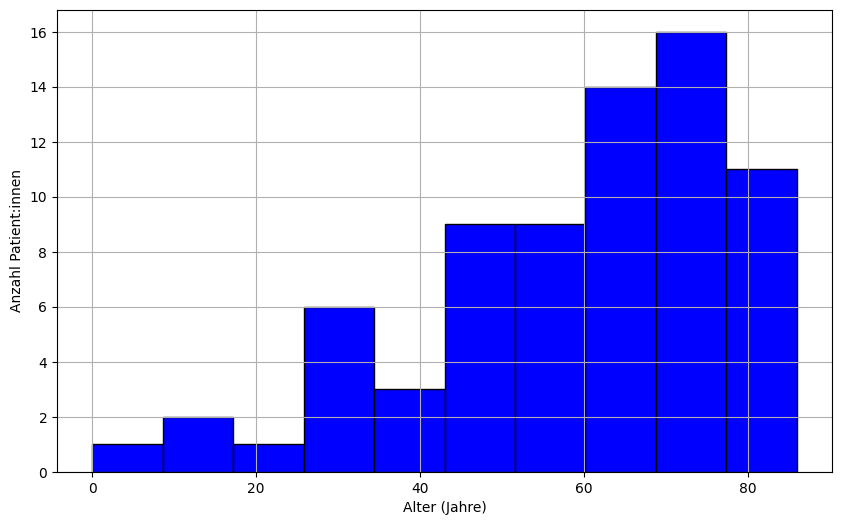

In [31]:
### Übung: Altersverteilung der onkologischen Patient:innen

# 1.1 Berechne das Alter bei Diagnose aus dem Geburtsdatum und Diagnosedatum und füge es als neue Spalte in den DataFrame ein
# Hinweis: diese Funktionen sind hilfreich: withColumn und
from pyspark.sql.functions import col, datediff, floor, to_date

patients_conditions = patients_conditions.withColumn(
    "birth_date", to_date(col("birth_date"))
).withColumn(
    "age_at_diagnosis",
    floor(datediff(col("date_diagnosis"), col("birth_date")) / 365.25),
)

patients_conditions.show(truncate=False)

# 1.2 Daten in Pandas überführen

patients_conditions_pd = patients_conditions.toPandas()

# 1.3 Zeichne ein Histogramm der Altersverteilung

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(
    patients_conditions_pd["age_at_diagnosis"].dropna(),
    bins=10,
    edgecolor="black",
    color="blue",
)
plt.xlabel("Alter (Jahre)")
plt.ylabel("Anzahl Patient:innen")
plt.grid(True)
plt.show()

# 3.  GRUPPENARBEIT
### 4 ENTITÄTEN:
##### (Quelle zugegebenermaßen aus Zeitgründen ChatGPT und stichprobenartig überprüft - falls hier etwas gar nicht passt, bitte melden :) )
### 1. Ösophagus C15
#### (Speiseröhrenkrebs)

    Häufigkeit: Relativ selten, aber mit hoher Sterblichkeitsrate – etwa 5.000–6.000 Neuerkrankungen pro Jahr in Deutschland.

    Typen: Zwei Hauptformen – Plattenepithelkarzinom (oberer/mittlerer Ösophagus) und Adenokarzinom (unterer Ösophagus).

    Risikofaktoren: Rauchen, Alkohol, Refluxkrankheit (Barrett-Ösophagus), Adipositas.

    Symptome: Schluckbeschwerden (Dysphagie), Gewichtsverlust, Brustschmerzen.

    Prognose: Sehr schlecht; 5-Jahres-Überlebensrate liegt bei unter 20 %, oft wegen später Diagnose.
### 2. Colon C18
#### (Dickdarmkrebs, ohne Rektum)

    Häufigkeit: Eine der häufigsten Krebsarten – etwa 33.000 Neuerkrankungen pro Jahr in Deutschland.

    Früherkennung: Darmspiegelung (Koloskopie) ab 50 (Männer) bzw. 55 (Frauen) empfohlen.

    Risikofaktoren: Ernährung (viel rotes Fleisch, wenig Ballaststoffe), familiäre Belastung, chronisch entzündliche Darmerkrankungen.

    Symptome: Blut im Stuhl, Veränderungen des Stuhlgangs, unklare Bauchschmerzen.

    Prognose: Bei früher Diagnose gute Heilungschancen – 5-Jahres-Überlebensrate >60 %.
### 3. Pankreas C25
#### (Bauchspeicheldrüsenkrebs)

    Häufigkeit: Etwa 20.000 Neuerkrankungen jährlich in Deutschland, steigende Tendenz.

    Typ: Meist duktales Adenokarzinom des Pankreaskopfes.

    Risikofaktoren: Rauchen, chronische Pankreatitis, Diabetes mellitus, genetische Prädisposition.

    Symptome: Unspezifisch – Gewichtsverlust, Oberbauchschmerzen, Ikterus (Gelbsucht).

    Prognose: Sehr schlecht – 5-Jahres-Überlebensrate unter 10 %, meist späte Diagnose.
### 4. Gliom C71
#### (Hirntumor, maligner, z. B. Glioblastom)

    Häufigkeit: Etwa 6.000–8.000 neue primäre Hirntumoren pro Jahr in Deutschland, davon viele Gliome.

    Typen: Astrozytom, Oligodendrogliom, Glioblastom (besonders aggressiv).

    Risikofaktoren: Meist unklar; wenige bekannte genetische Syndrome (z. B. Li-Fraumeni).

    Symptome: Kopfschmerzen, epileptische Anfälle, neurologische Ausfälle (z. B. Lähmungen, Sprachstörungen).

    Prognose: Stark abhängig vom Grad – Glioblastome (WHO Grad IV) haben eine mittlere Überlebenszeit von ca. 15 Monaten trotz Therapie.
### Aufgabe: Wählt eine Entität aus (jede Entität sollte von mind. einer Gruppe gewählt werden) und führt folgende Analysen durch.
#### 3.1: Wie häufig ist die Diagnose?
#### 3.2: Wie ist die Diagnoseverteilung zwischen den Geschlechtern verteilt?
#### 3.3: Wie sieht die Altersverteilung der Diagnose aus? Visualisiere das Ergebnis, z.B. in einem Histogramm.
#### 3.4: Therapieanalyse: Operation, Strahlentherapie
#### 3.5: Freie Auswertung - was interessiert dich noch innerhalb deiner Kohorte?

In [46]:
# Lösung 3.1 für C25 Kohorte
patients_conditions_c25 = patients_conditions.filter(
    col("icd10_code").startswith("C25")
)

patients_conditions_c25 = patients_conditions_c25.checkpoint(eager=True)
patients_conditions_c25_count = patients_conditions_c25.count()

print("patients_conditions_c25_count =", patients_conditions_c25_count)

print(
    "distinct condition ids count =",
    patients_conditions_c25.select("condition_resource_id").distinct().count(),
)

patients_conditions_c25_count = 19
distinct condition ids count = 19


In [47]:
patients_conditions_c25.show()

+---------------------+----------+--------------+---------------------------+-------------------+----------------+------+----------+-----------------+----------------+
|condition_resource_id|icd10_code|date_diagnosis|condition_subject_reference|patient_resource_id| patid_pseudonym|gender|birth_date|deceased_datetime|age_at_diagnosis|
+---------------------+----------+--------------+---------------------------+-------------------+----------------+------+----------+-----------------+----------------+
|     4e8432e66cce4dc4|     C25.0|    2024-09-01|           f44db4a5131c0ae2|   f44db4a5131c0ae2|10e14a11759058db|female|1945-06-01|             NULL|              79|
|     e72e5f5440a7ffc5|     C25.0|    2022-07-06|           114b17715cd8962f|   114b17715cd8962f|7a258cbfec3c558c|  male|1948-12-06|       2023-11-10|              73|
|     96fe81bd47dd30e1|     C25.0|    2018-01-23|           9ba79939ecbcae8f|   9ba79939ecbcae8f|550d43f7d5cc0b99|  male|1952-03-09|       2019-04-09|          

In [48]:
# Lösung 3.2 für C25 Kohorte

female = patients_conditions_c25.filter(col("gender") == "female").count()
male = patients_conditions_c25.filter(col("gender") == "male").count()

print("female:", female, ", male:", male)

female: 9 , male: 10


+---------------------+----------+--------------+---------------------------+-------------------+----------------+------+----------+-----------------+----------------+
|condition_resource_id|icd10_code|date_diagnosis|condition_subject_reference|patient_resource_id|patid_pseudonym |gender|birth_date|deceased_datetime|age_at_diagnosis|
+---------------------+----------+--------------+---------------------------+-------------------+----------------+------+----------+-----------------+----------------+
|4e8432e66cce4dc4     |C25.0     |2024-09-01    |f44db4a5131c0ae2           |f44db4a5131c0ae2   |10e14a11759058db|female|1945-06-01|NULL             |79              |
|e72e5f5440a7ffc5     |C25.0     |2022-07-06    |114b17715cd8962f           |114b17715cd8962f   |7a258cbfec3c558c|male  |1948-12-06|2023-11-10       |73              |
|96fe81bd47dd30e1     |C25.0     |2018-01-23    |9ba79939ecbcae8f           |9ba79939ecbcae8f   |550d43f7d5cc0b99|male  |1952-03-09|2019-04-09       |65        

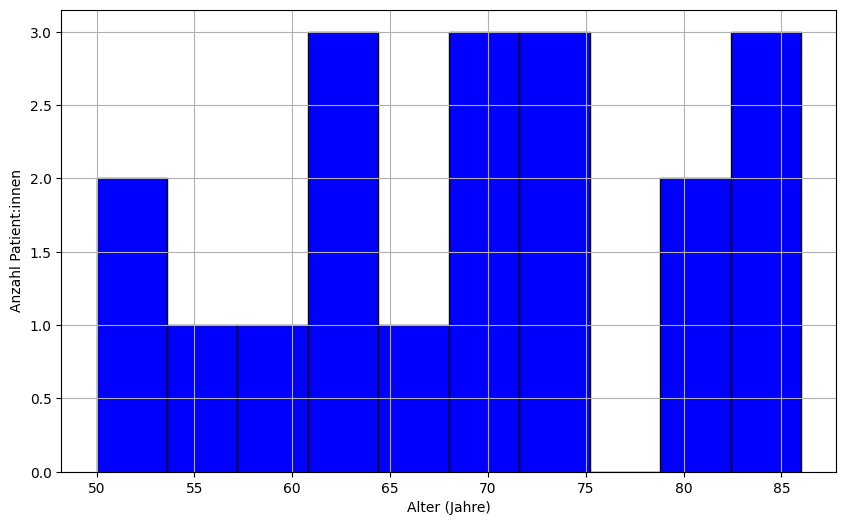

In [49]:
# Lösung 3.3 für C25 Kohorte
patients_conditions_c25 = patients_conditions_c25.withColumn(
    "birth_date", to_date(col("birth_date"))
).withColumn(
    "age_at_diagnosis",
    floor(datediff(col("date_diagnosis"), col("birth_date")) / 365.25),
)

patients_conditions_c25.show(truncate=False)

patients_conditions_c25 = patients_conditions_c25.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(
    patients_conditions_c25["age_at_diagnosis"].dropna(),
    bins=10,
    edgecolor="black",
    color="blue",
)
plt.xlabel("Alter (Jahre)")
plt.ylabel("Anzahl Patient:innen")
plt.grid(True)
plt.show()

### 3.4: Therapieanalyse

#### OPERATION -- RESOURCENTYP: PROCEDURE
https://simplifier.net/guide/mii-ig-modul-onkologie-2024-de/MIIIGModulOnkologie/TechnischeImplementierung/FHIR-Profile/Operation/Operation-Procedure.page.md?version=current

In [ ]:
# 3.4 Operationen: untersuche wie häufig deine Kohorte die Therapieform Operation erhält.

# Extrahiere die folgenden Spalten: op resource id, category, op_date, op intention, OPS Code + icd10 code und condition_resource_id der zugrundeliegenden Diagnose
# Welche OP Intentionen findest du in deiner Kohorte, wie oft kommen sie jeweils vor und wofür stehen die Codes? (Stichwort ValueSet im Implementation Guide)
# Extrahiere hierfür die entsprechende Extension (analog zum Diagnosedatum im Einführungsbeispiel).

# Hinweise
# - mithilfe der folgenden Snomed CT category.coding.codes kannst du Operationen filtern:
# 387713003 - Surgical procedure
# 165197003 - Diagnostic assessment
# 394841004 - Other category

# - über Procedure.reasonReference hast du die Verbindung zur zugrundeliegenden Condition Resource = Diagnose.
# - überprüfe dringend jederzeit die distinct op_resource_ids und betrachte den gesamten dataframe, um sicherzustellen, dass du keine duplizierten Zeilen erzeugt hast.

#### STRAHLENTHERAPIE -- RESOURCENTYP: PROCEDURE
https://simplifier.net/guide/mii-ig-modul-onkologie-2024-de/MIIIGModulOnkologie/TechnischeImplementierung/FHIR-Profile/Strahlentherapie/Strahlentherapie-Procedure.page.md?version=current

In [ ]:
# 3.4 Strahlentherapie: untersuche wie häufig deine Kohorte die Therapieform Strahlentherapie erhält.

# Extrahiere die folgenden Spalten: st resource id, category, st_start_date und st_end_date und st_datetime, op intention, OPS Code + icd10 code und condition_resource_id der zugrundeliegenden Diagnose
# Welche OP Intentionen findest du in deiner Kohorte, wie oft kommen sie jeweils vor und wofür stehen die Codes? (Stichwort ValueSet im Implementation Guide)
# Extrahiere hierfür die entsprechende Extension (analog zum Diagnosedatum im Einführungsbeispiel).

# Hinweise
# - mithilfe der folgenden Snomed CT category.coding.codes kannst du Operationen filtern:
# "1287742003" Radiotherapy (procedure)
# "399315003" Radionuclide therapy (procedure)

# - über Procedure.reasonReference hast du die Verbindung zur zugrundeliegenden Condition Resource = Diagnose.
# - überprüfe dringend jederzeit die distinct st_resource_ids und betrachte den gesamten dataframe, um sicherzustellen, dass du keine duplizierten Zeilen erzeugt hast.


# 3.4 Operationen - Lösung:

### 3.5: Freie Auswertung - was interessiert dich noch innerhalb deiner Kohorte?
#### Aufgabe: überlege dir deine eigene Auswertung, erzeuge ggf. einen anschaulichen Plot
#### Inspiration: Geschlecht/Altersverteilung der Therapieformen